# Branch DS Project

In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
import pickle

%matplotlib inline

Data Access

In [2]:
from dotenv import load_dotenv
load_dotenv()
# Database connection parameters
HOST = 'branchhomeworkdb.cv8nj4hg6yra.ap-south-1.rds.amazonaws.com'
PORT = '5432'
USER = 'datascientist'
PASSWORD = os.getenv('DB_PASSWORD')
DATABASE = 'branchdsprojectgps'

# Database Engine
engine = create_engine(f'postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}')

# To read data from the tables
loan_outcomes = pd.read_sql('SELECT * FROM loan_outcomes', engine)
gps_fixes = pd.read_sql('SELECT * FROM gps_fixes', engine)
user_attributes = pd.read_sql('SELECT * FROM user_attributes', engine)

## Exploratory Data Analysis (EDA)

In [3]:
# Load Outcomes
loan_outcomes.head()

,user_id,application_at,loan_outcome
0,1,2017-08-14 09:08:50.000000,defaulted
1,2,2016-05-17 10:10:12.447976,repaid
2,3,2016-10-20 10:07:20.459081,defaulted
3,4,2017-01-13 13:03:34.000000,defaulted
4,5,2016-11-03 15:41:39.124610,repaid


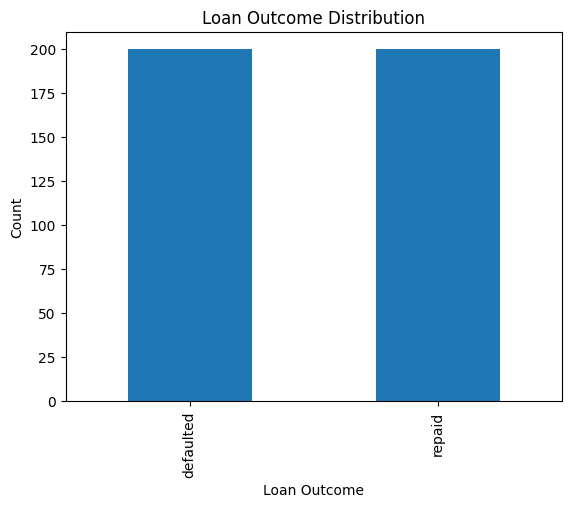

In [4]:
loan_outcomes['loan_outcome'].value_counts().plot(kind='bar')
plt.title('Loan Outcome Distribution')
plt.xlabel('Loan Outcome')
plt.ylabel('Count')
plt.show()

In [5]:
# User Attributes
user_attributes.head()

,user_id,age,cash_incoming_30days
0,1,42,8988.12
1,2,36,9968.12
2,3,27,59.04
3,4,38,2129.03
4,5,33,2102.53


In [6]:
user_attributes.describe()

,user_id,age,cash_incoming_30days
count,400.000000,400.000000,400.000000
mean,200.500000,36.487500,7896.301075
std,115.614301,13.243236,7037.481340
min,1.000000,18.000000,11.900000
25%,100.750000,27.000000,2602.472500
50%,200.500000,34.000000,6004.240000
75%,300.250000,44.000000,10989.405000
max,400.000000,105.000000,41657.810000


In [7]:
# GPS Fixes
gps_fixes.head()

,gps_fix_at,server_upload_at,longitude,latitude,accuracy,altitude,bearing,location_provider,user_id
0,2017-06-22 09:37:20,2017-06-22 09:43:42,36.840540,-1.294342,68.4,0.0,0.0,fused,1
1,2017-08-14 07:50:27,2017-08-14 09:05:27,36.895270,-1.341928,1409.0,0.0,0.0,fused,1
2,2017-06-13 10:34:29,2017-06-13 10:54:48,36.811903,-1.307220,68.4,0.0,0.0,fused,1
3,2017-06-18 12:16:20,2017-06-18 12:16:24,36.907049,-1.309984,1581.0,0.0,0.0,fused,1
4,2017-06-28 09:39:08,2017-06-28 09:58:12,36.839396,-1.280310,1396.0,0.0,0.0,fused,1


In [8]:
# Number of GPS fixes per user
gps_counts = gps_fixes['user_id'].value_counts()
gps_counts.describe()

count     372.000000
mean       71.801075
std       111.022414
min         1.000000
25%        16.000000
50%        42.000000
75%        94.250000
max      1615.000000
Name: count, dtype: float64

## Data Preprocessing and Feature Engineering

Merge DataFrames

In [9]:
# Merge loan outcomes with user attributes
df = pd.merge(loan_outcomes, user_attributes, on='user_id', how='left')

### Feature Engineering with GPS Data

We can engineer features like:
1. Number of GPS fixes
2. Average accuracy
3. Average speed
4. Mobility patterns

In [10]:
# Number of GPS fixes per user
gps_features = gps_fixes.groupby('user_id').agg({
    'accuracy': ['mean', 'std'],
    'latitude': ['mean', 'std'],
    'longitude': ['mean', 'std']
})


gps_features.columns = ['_'.join(col) for col in gps_features.columns]
gps_features = gps_features.reset_index()
df = pd.merge(df, gps_features, on='user_id', how='left')

In [11]:
# To handle missing values
# Filling missing values with median for numerical features

numerical_cols = ['age', 'cash_incoming_30days', 'accuracy_mean', 'accuracy_std']
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

In [12]:
# Encoding Categorical variables
# Encode loan outcome
df['loan_outcome'] = df['loan_outcome'].map({'repaid': 1, 'defaulted': 0})

## Feature Selection and Model Training

In [13]:
# Features and target variable
features = ['age', 'cash_incoming_30days', 'accuracy_mean', 'accuracy_std']
X = df[features]
y = df['loan_outcome']

In [14]:
# Splitting into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Model Training

In [15]:
# Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)

# A loop for hyperparameter tuning (Just for choosing best combination)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
}

grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

### Model Evaluation

In [16]:
# Predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.72      0.72        40
           1       0.72      0.70      0.71        40

    accuracy                           0.71        80
   macro avg       0.71      0.71      0.71        80
weighted avg       0.71      0.71      0.71        80



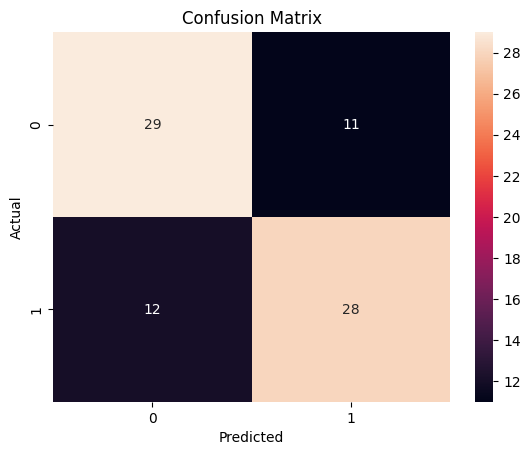

In [17]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

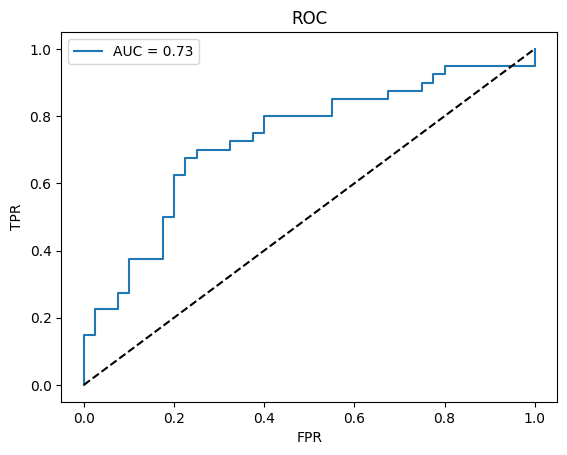

In [18]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

In [19]:
# Dumping the model
with open('model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [20]:
numerical_cols = ['age', 'cash_incoming_30days', 'accuracy_mean', 'accuracy_std']
median_values = df[numerical_cols].median()
df[numerical_cols] = df[numerical_cols].fillna(median_values)
with open('median_values.pkl', 'wb') as f:
    pickle.dump(median_values, f)

In [21]:
user_ids = loan_outcomes['user_id'].unique()
print(user_ids)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24